In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from fit import likelihood, stat_fit
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)

# NEF models vs human choices

missing model-RL sid 24


/tmp/ipykernel_112711/771944440.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))


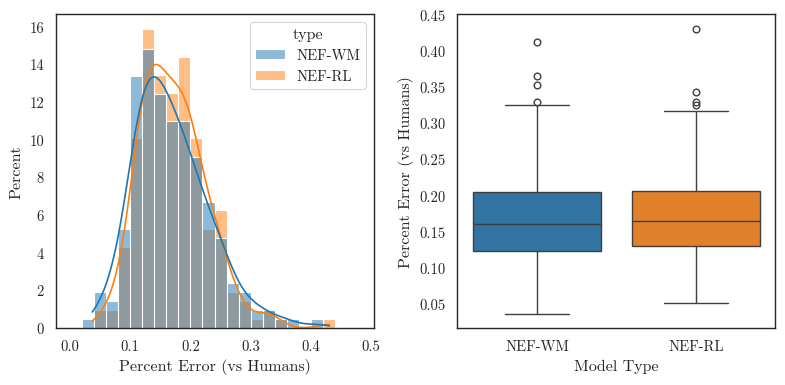

In [10]:
WM = pd.read_pickle(f"data/WM_z05k12.pkl").query("type=='model-WM'")
RL = pd.read_pickle(f"data/RL_z05k12.pkl").query("type=='model-RL'")
combined = pd.concat([WM, RL], ignore_index=True)

dfs = []
columns = ['type', 'sid', 'percent error']
for model_type in combined['type'].unique():
    for sid in combined['sid'].unique():
        subdata = combined.query("type==@model_type & sid==@sid")
        errors = subdata['error'].to_numpy()
        if len(errors)==0:
            print(f"missing {model_type} sid {sid}")
            continue
        percent_error = np.sum(errors) / len(errors)
        type_label = "NEF-WM" if model_type=='model-WM' else "NEF-RL"
        df = pd.DataFrame([[type_label, sid, percent_error]], columns=columns)
        dfs.append(df)
reduced = pd.concat(dfs, ignore_index=True)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0.0, 0.5, 0.02)
sns.histplot(reduced, x='percent error', hue='type', ax=axes[0], palette=palette[:2], stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(reduced, x='type', y='percent error', hue='type', ax=axes[1], palette=palette[:2])
axes[0].set(xlabel="Percent Error (vs Humans)") 
axes[1].set(xlabel="Model Type", ylabel='Percent Error (vs Humans)') 
plt.tight_layout()
fig.savefig("plots/nef_errors.png", dpi=600)

# NEF models (+probablistic choice) vs Statistical Models

In [2]:
fitted_data, fitted_params = stat_fit("DG", 1, save=False)

In [3]:
print(fitted_data)
print(fitted_params)

  type  sid        NLL  McFadden R2
0   DG    1  57.156167     0.484632
[8.36651469]


In [12]:
# start = time.time()
# model_type = "RL1"
# sids = pd.read_pickle(f"data/behavior.pkl")['sid'].unique()
# dfs = []
# for sid in sids:
#     print(sid)
#     df = stat_fit(model_type, sid, save=False)
#     dfs.append(df)
# fitted = pd.concat(dfs, ignore_index=True)
# fitted.to_pickle(f"data/fitted_{model_type}.pkl")
# end = time.time()
# print(f"runtime {(end-start)/60:.4} min")

/tmp/ipykernel_134473/3494333008.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))


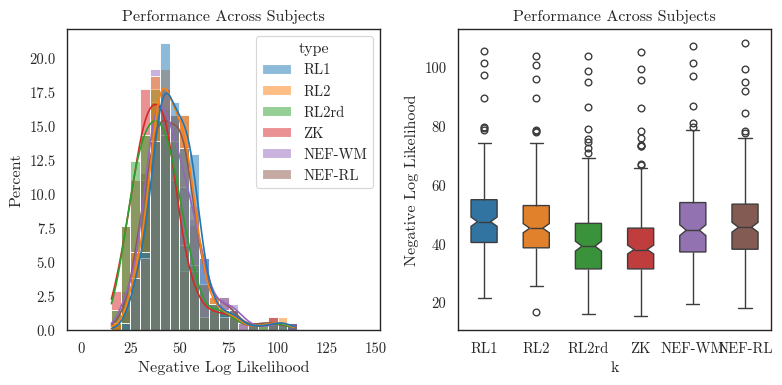

In [4]:
fitted_NEF_WM = pd.read_pickle(f"data/NEF-WM_remote.pkl")
fitted_NEF_RL = pd.read_pickle(f"data/NEF-RL_remote.pkl")
fitted_RL1 = pd.read_pickle(f"data/RL1_remote.pkl")
fitted_RL1rd = pd.read_pickle(f"data/RL1rd_remote.pkl")
fitted_RL2 = pd.read_pickle(f"data/RL2_remote.pkl")
fitted_RL2rd = pd.read_pickle(f"data/RL2rd_remote.pkl")
fitted_ZK = pd.read_pickle(f"data/ZK_remote.pkl")
combined = pd.concat([fitted_RL1, fitted_RL2, fitted_RL2rd, fitted_ZK, fitted_NEF_WM, fitted_NEF_RL], ignore_index=True)
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
bins = np.arange(0, 150, 5)
types = combined['type'].unique()

sns.histplot(combined, x='NLL', hue='type', ax=axes[0], palette=palette[:len(types)],
             stat='percent', bins=bins, kde=True, common_norm=False)
sns.boxplot(combined, x='type', y='NLL', hue='type', ax=axes[1], palette=palette[:len(types)],
           notch=True, width=0.5)
axes[0].set(xlabel="Negative Log Likelihood", title="Performance Across Subjects") 
axes[1].set(xlabel="k", ylabel='Negative Log Likelihood', title="Performance Across Subjects") 
plt.tight_layout()
fig.savefig("plots/fitted.png", dpi=600)

In [8]:
fitted_ZK

,type,sid,NLL
0,ZK,1,44.024668
1,ZK,2,44.591214
2,ZK,3,43.489326
3,ZK,4,42.282890
4,ZK,5,65.895611
...,...,...,...
204,ZK,220,45.478240
205,ZK,221,39.413147
206,ZK,222,29.125997
207,ZK,223,22.263321
